<a href="https://colab.research.google.com/github/tayyib-saddique/bbk-ds/blob/main/week6/trade_networks_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DSTA


#### Chapter II - International Trade Networks and World Trade Web

##### This lab notebook is taken from the notebook for Ch. 2 of Caldarelli-Cheesa's textbook (CC).

There is only one question, which is about visualising the trade network rooted in the UK.

Please see the [class repo](https://github.com/ale66/learn-datascience/tree/main/week-6/Trade_networks_notebook) for a local image of the data.


### Downloading the datasets from Comtrade

#### Starting from the [Comtrade](http://comtrade.un.org/) web site it is possible to download the datasets related to the International Trade.

#### Starting from the [Express Selection](http://comtrade.un.org/db/dqQuickQuery.aspx) interface that you can reach through the path:
* comtrade.un.org/Legacy Annual
* data/Data Query/Express Selection

#### It is possible to get Comtrade data related to 'Total' transactions ('Import' and 'Export') among 'All' countries for a specific year, in our case 2003.

#### (For specific products, instead of total put the code. For example 93 for Arms)

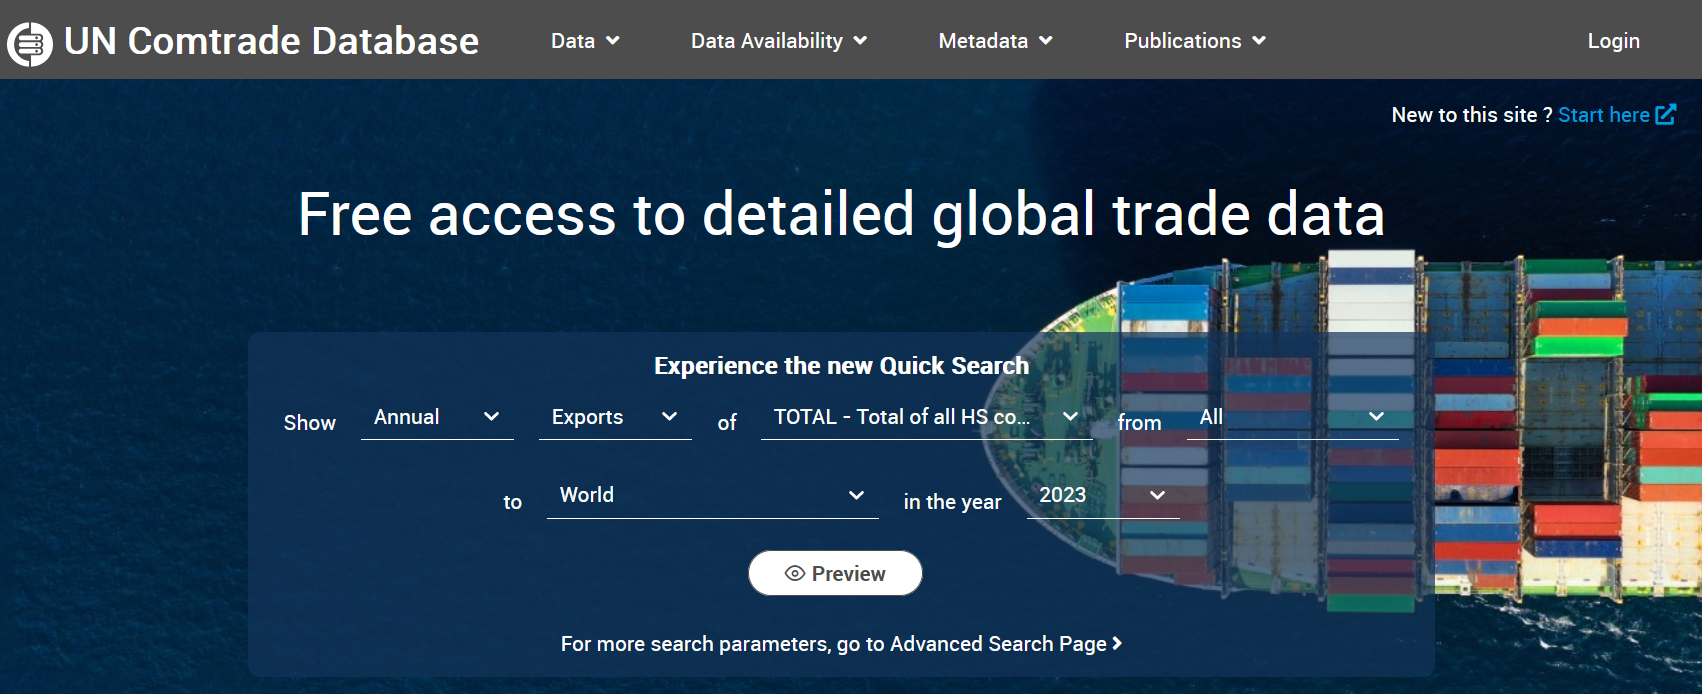

In [ ]:
from IPython.display import Image

FILE = './imgs/comtrade-2024-land.png'
Image(filename=FILE)

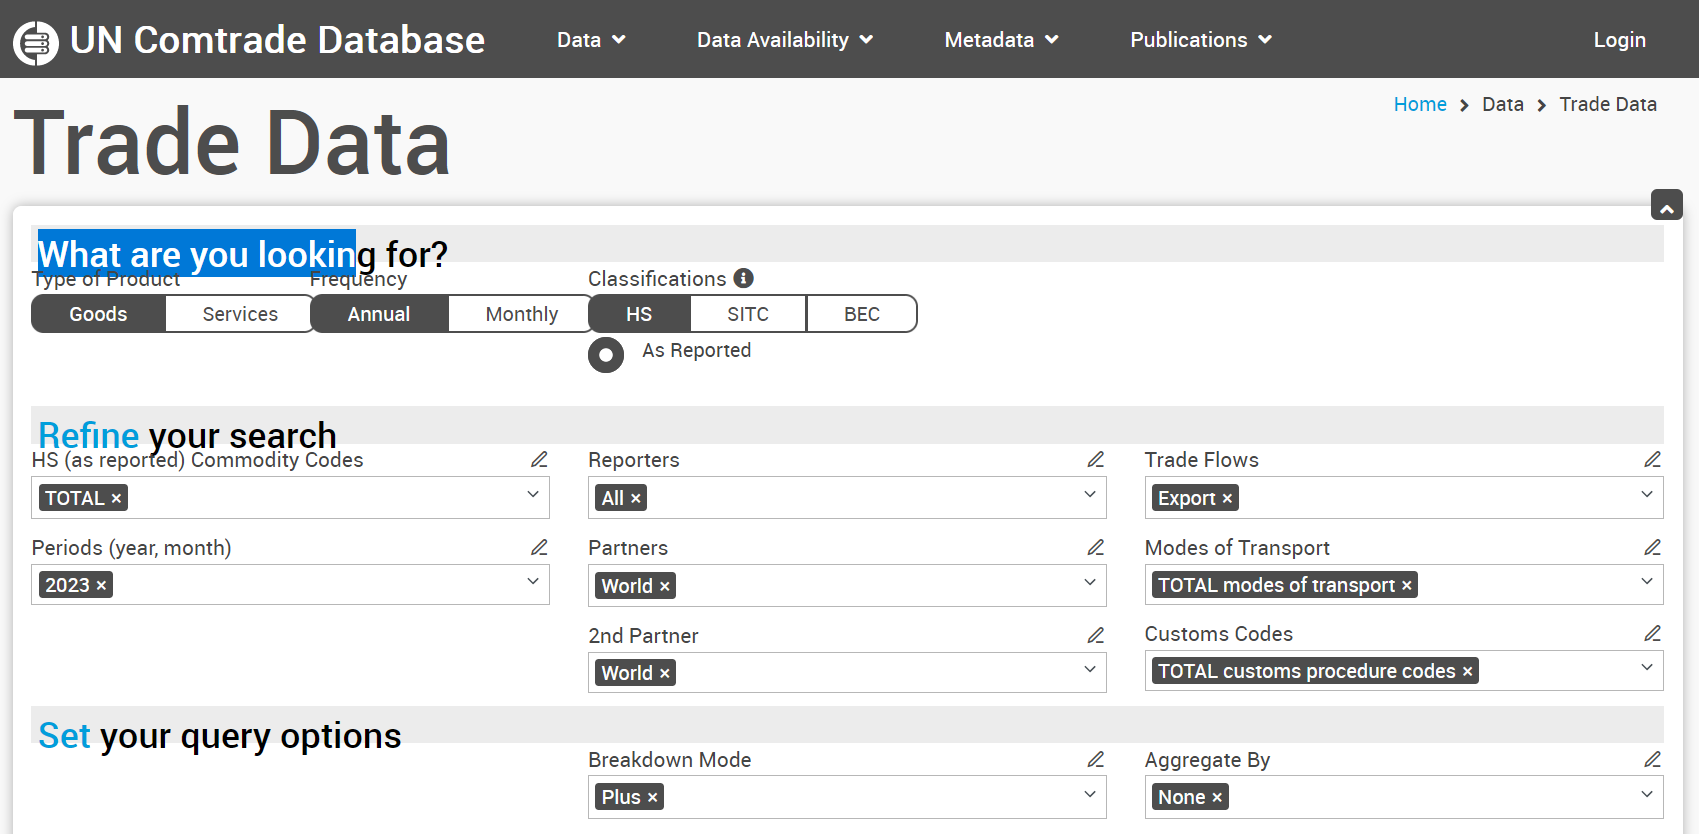

In [ ]:
FILE2 = './imgs/comtrade-2024-search.png'
Image(filename=FILE2)

#### From the class repo all CSV files for 2003 can be obtained through the link 'Direct Download'

In [ ]:
# uncomment for lin/colab execution:
%ls data/comtrade_trade*

# uncomment for win execution
# !dir data/comtrade_trade*

data/comtrade_trade_data_2003_product_09.csv
data/comtrade_trade_data_2003_product_10.csv
data/comtrade_trade_data_2003_product_27.csv
data/comtrade_trade_data_2003_product_29.csv
data/comtrade_trade_data_2003_product_30.csv
data/comtrade_trade_data_2003_product_39.csv
data/comtrade_trade_data_2003_product_52.csv
data/comtrade_trade_data_2003_product_71.csv
data/comtrade_trade_data_2003_product_72.csv
data/comtrade_trade_data_2003_product_84.csv
data/comtrade_trade_data_2003_product_85.csv
data/comtrade_trade_data_2003_product_87.csv
data/comtrade_trade_data_2003_product_90.csv
data/comtrade_trade_data_2003_product_93.csv
data/comtrade_trade_data_total_2003.csv


### Check the data file

In [ ]:
# lin/colab only command!
!head data/comtrade_trade_data_2003_product_09.csv

Year,Reporter Code,Trade Flow Code,Partner Code,Classification,Commodity Code,Quantity Unit Code,Supplementary Quantity,Netweight (kg),Value,Estimation Code
2003,8,1,0,"H2","09",1,,,6447239,0
2003,8,2,0,"H2","09",1,,,410437,0
2003,8,1,40,"H2","09",1,,,4391,0
2003,8,1,76,"H2","09",1,,,1829986,0
2003,8,1,100,"H2","09",1,,,2018,0
2003,8,2,100,"H2","09",1,,,16851,0
2003,8,1,156,"H2","09",1,,,5775,0
2003,8,1,188,"H2","09",1,,,42938,0
2003,8,1,203,"H2","09",1,,,51,0


### Special 'Country codes' to be exluded when loading data

* 472	Africa CAMEU region, nes
* 899	Areas, nes
* 471	CACM, nes
* 129	Caribbean, nes
* 221	Eastern Europe, nes
* 97	 EU-27
* 697	Europe EFTA, nes
* 492	Europe EU, nes
* 838	Free Zones
* 473	LAIA, nes
* 536	Neutral Zone
* 637	North America and Central America, nes
* 290	Northern Africa, nes
* 527	Oceania, nes
* 577	Other Africa, nes
* 490	Other Asia, nes
* 568	Other Europe, nes
* 636	Rest of America, nes
* 839	Special Categories
* 879	Western Asia, nes
* 0      World


## Network Symmetrisation

In [ ]:
# Import packages
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def net_symmetrisation(
    input_file: str,
    excluded_countries: list[int]
) -> nx.DiGraph:
    """
    Network symmetrisation: Described in section 2.3 of
    chapter 2 in Caldarelli's book.

    :param input_file: Input file path.
    :param excluded_countries: List of integers indicating
    codes of countries to be excluded.

    :return: The symmetrised directed graph.
    """
    dir_graph = nx.DiGraph()

    # Column Indexes
    reporter_pos = 1
    partner_pos = 3
    flow_code_pos = 2
    value_pos = 9

    # Parse file and create directed graph
    dic_trade_flows = {}
    hfile = open(input_file,'r')

    # Skip the first row (data header)
    _ = hfile.readline()
    lines = hfile.readlines()

    for l in lines:
        l_split = l.split(',')

        # the following is to prevent parsing lines without data
        if len(l_split) < 2:
            continue

        reporter = int(l_split[reporter_pos])
        partner = int(l_split[partner_pos])
        flow_code = int(l_split[flow_code_pos])
        value = float(l_split[value_pos])

        if any([
            reporter in excluded_countries,
            partner in excluded_countries,
            reporter == partner
            ]):
            continue

        # Flow code = 1: Import | Flow code = 2: Export
        # Aggregation: export i -> j is not equal to import j -> i
        # Therefore: Export ij = (Export ij + Import ji) / 2
        if flow_code == 1 and value > 0.0:
            if (partner, reporter, 2) in dic_trade_flows:
                dir_graph[partner][reporter]['weight'] = \
                 (dir_graph[partner][reporter]['weight'] + value) / 2.0

            else:
                dir_graph.add_edge(partner, reporter, weight=value)

                # This is to mark the existence of the link
                dic_trade_flows[(partner, reporter, 1)] = value

        elif flow_code == 2 and value > 0.0:
            if  (reporter, partner, 1) in dic_trade_flows:
                dir_graph[reporter][partner]['weight'] = \
                 (dir_graph[reporter][partner]['weight'] + value) / 2.0

            else:
                dir_graph.add_edge(reporter, partner, weight=value)

                # This is to mark the existence of the link
                dic_trade_flows[(reporter, partner, 2)] = value
        else:
            print ("trade flow not present\n")

    hfile.close()
    return dir_graph

## Generate the aggregate network
### Q1. Generate an undirected  trade network for UK using country code: 826

Populating the interactive namespace from numpy and matplotlib
number of nodes 232
number of edges 27901


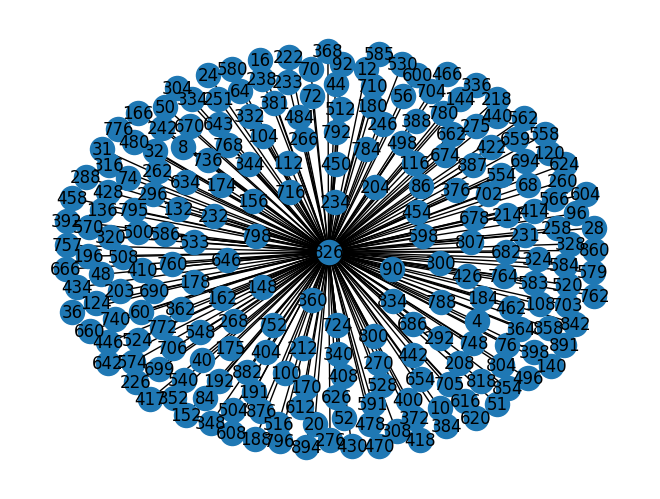

In [ ]:
# Countries to be excluded
excluded_codes = [
    472, 899, 471, 129, 221, 97, 697, 492, 838, 473,
    536, 637, 290, 527, 577, 490, 568, 636, 839, 879, 0
    ]

# Magic command to embed the graphic in the notebook
# SOS: It imports numpy functions in the background e.g., numpy.min()
%pylab inline

total_data_csv = "data/comtrade_trade_data_total_2003.csv"
graph = net_symmetrisation(total_data_csv, excluded_codes)

print("number of nodes", graph.number_of_nodes())
print("number of edges", graph.number_of_edges())

# Create graph for the UK - UK country code is 826
uk_code = 826
uk_graph = nx.Graph()
uk_graph.add_nodes_from([uk_code])

# Create edges and add them
edges = [(uk_code, key) for key in graph.__getitem__(uk_code)]
uk_graph.add_edges_from(edges)
nx.draw(uk_graph, with_labels=True)

## Reciprocity

We can define both the reciprocity in the unweighted case as:
$$r=\frac{L^\leftrightarrow}{L}$$
where $${L^\leftrightarrow}$$ is the number of reciprocated links that for a connected network ammounts to $$2L-N(N-1)$$


In [ ]:
# Unweighted case
N = graph.number_of_nodes()
L = graph.number_of_edges()

r = float((2*L - N*(N - 1))) / L
print(round(r, 4))

0.0792


In the weighted case the formula changes in:

$$r=\frac{W^\leftrightarrow}{W}$$

where

$$W^\leftrightarrow=\sum_i\sum_{j\neq i}w^\leftrightarrow_{ij}$$

is the sum of the reciprocated weights with

$$w^\leftrightarrow_{ij}=min[w_{ij},w_{ji}]=w^\leftrightarrow_{ji}$$

and $$W=\sum_i\sum_{j\neq i}w_{ij}.$$

In [ ]:
# Weighted case
W = 0
W_rep = 0

for n in graph.nodes():
    for e in graph.out_edges(n, data=True):
        W += e[2]['weight']
        if graph.has_edge(e[1], e[0]):
            W_rep += min([
                graph[e[0]][e[1]]['weight'],
                graph[e[1]][e[0]]['weight']
            ])

print(W, W_rep, W_rep / W)

7177664759252.5 5196276060567.0 0.723950788293455


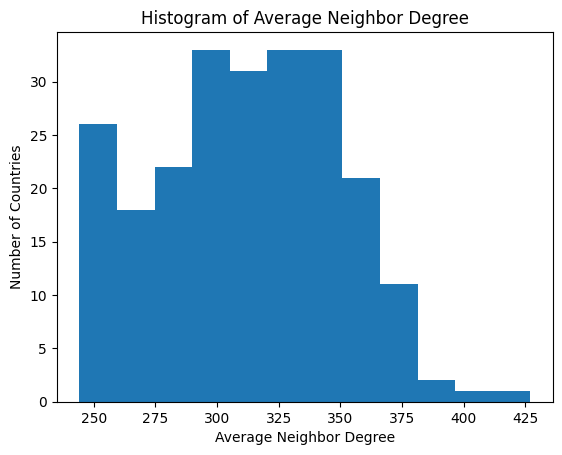

In [ ]:
# Assortativity with neighbor nodes degree
list_knn = []

for n in graph.nodes():
    degree = 0

    for nn in graph.neighbors(n):
        degree += graph.degree(nn)
    list_knn.append(degree / len(list(graph.neighbors(n))))

# plot the histogram
plt.hist(list_knn, bins=12)
plt.xlabel("Average Neighbor Degree")
plt.ylabel("Number of Countries")
plt.title("Histogram of Average Neighbor Degree")
plt.show()

In [ ]:
# Basic Pearson correlation coefficient for the graph
r = nx.degree_assortativity_coefficient(graph)
print(round(r, 4))

-0.335


### To compute the weighted version of the assortativity Networkx has extra parameters and also the possibility to decide for 'out' or 'in' degree correlations both for the source and target nodes (the default is x='out', y='in')

In [ ]:
# Weighted version
r = nx.degree_pearson_correlation_coefficient(
    graph, weight='weight', x='out', y='out'
    )

print(round(r, 4))

-0.0697


## Density and Strength (in and out)

### Load Product Networks

In [ ]:
product_nets_dict = {}
commodity_codes = [
    '09','10','27','29','30','39','52',
    '71','72','84','85','87','90','93'
    ]

for c in commodity_codes:
    csv_file = "data/comtrade_trade_data_2003_product_" + c + ".csv"
    product_nets_dict[c] = net_symmetrisation(csv_file, excluded_codes)

# Recreate symmetrised directed graph
total_data_csv = "data/comtrade_trade_data_total_2003.csv"
aggr_graph = net_symmetrisation(total_data_csv, excluded_codes)

### Rescale the weighted ajacency aggregate matrix
$$w_{ij}^{tot}=\frac{ w_{ij}^{tot} }{ \sum_{hk}w_{hk}^{tot} }$$

In [ ]:
# Rescale the weights
w_tot = 0.0

for u, v, d  in aggr_graph.edges(data=True):
    w_tot += d['weight']

for u, v, d in aggr_graph.edges(data=True):
    d['weight'] = d['weight'] / w_tot

#### Rescale the weighted adjacency product matrices

$$w_{ij}^c=\frac{w_{ij}^c}{\sum_{hk}w_{hk}^c}$$

In [ ]:
# Rescale the weights for the products
for c in commodity_codes:
    l_p = []
    w_tot = 0.0

    for u, v, d in product_nets_dict[c].edges(data=True):
        w_tot += d['weight']

    for u,v,d in product_nets_dict[c].edges(data=True):
        d['weight'] = d['weight'] / w_tot

#### Generate the table with the quantities

Here a rather cumbersome code computes the *densities* defined as follows:

for each relationship $w_{ij}$ we compute its fraction of the import, $\frac{NS_{in}}{ND_{in}}$, divided by its fraction of the export, $\frac{NS_{out}}{ND_{out}}$.

No need to go over the code line-by-line.

In [ ]:
aggr_n_edges = aggr_graph.number_of_edges()
aggr_n_nodes = aggr_graph.number_of_nodes()
density_aggregate = aggr_n_edges / (aggr_n_nodes * (aggr_n_nodes - 1.0))

w_agg = []
NS_in = []
NS_out = []

for u, v, d in aggr_graph.edges(data=True):
    w_agg.append(d['weight'])

for n in aggr_graph.nodes():
    if aggr_graph.in_degree(n) > 0:

        incoming_weight_sum = aggr_graph.in_degree(n, weight='weight')
        incoming_degree = aggr_graph.in_degree(n)

        NS_in.append(incoming_weight_sum / incoming_degree)

    if aggr_graph.out_degree(n) > 0:

        outcoming_weight_sum = aggr_graph.out_degree(n, weight='weight')
        outcoming_degree = aggr_graph.out_degree(n)

        NS_out.append(outcoming_weight_sum / outcoming_degree)

for c in commodity_codes:
    n_edges = product_nets_dict[c].number_of_edges()
    n_nodes = product_nets_dict[c].number_of_nodes()

    density_commodity = n_edges / (n_nodes * (n_nodes - 1.0))

    w_c = []
    NS_c_in = []
    NS_c_out = []

    for u, v, d  in product_nets_dict[c].edges(data=True):
        w_c.append(d['weight'])

    for n in product_nets_dict[c].nodes():
        if product_nets_dict[c].in_degree(n) > 0:

            incoming_weight_sum = product_nets_dict[c].in_degree(n, weight='weight')
            incoming_degree = product_nets_dict[c].in_degree(n)

            NS_c_in.append(incoming_weight_sum / incoming_degree)

        if product_nets_dict[c].out_degree(n) > 0:

            outcoming_weight_sum = product_nets_dict[c].out_degree(n, weight='weight')
            outcoming_degree = product_nets_dict[c].out_degree(n)

            NS_c_out.append(outcoming_weight_sum / outcoming_degree)

    print(c, str(round(density_commodity / density_aggregate, 4)) + " & " + \
          str(round(np.mean(w_c) / np.mean(w_agg), 4)) + " & " + \
          str(round(np.mean(NS_c_in) / np.mean(NS_in), 4)) + " & " + \
          str(round(np.mean(NS_c_out) / np.mean(NS_out), 4)))


09 0.309 & 3.3811 & 2.553 & 2.3906
10 0.1961 & 5.5195 & 5.9919 & 2.5718
27 0.3057 & 3.3575 & 2.6786 & 3.2979
29 0.3103 & 3.3664 & 2.3579 & 1.6286
30 0.3662 & 2.803 & 2.3308 & 1.267
39 0.4926 & 2.0478 & 1.753 & 1.1385
52 0.2864 & 3.5839 & 2.7572 & 2.1254
71 0.2843 & 3.6746 & 1.9479 & 2.6704
72 0.3081 & 3.3315 & 2.5847 & 1.8484
84 0.6195 & 1.6281 & 1.3359 & 1.0259
85 0.5963 & 1.6917 & 1.3518 & 1.0692
87 0.4465 & 2.259 & 1.7488 & 1.1105
90 0.4734 & 2.1492 & 1.5879 & 1.0993
93 0.1415 & 8.4677 & 6.0618 & 4.0279


#### Balassa's Revealed Comparative Advantage


Please see the formula on the textbook and read the code to understand how it has been implemented.

Let's begin by setting up a specific country and product.

In [ ]:
# Arms & ammunition
product = '93'

# contry Republic of Serbia
country = 381

In [ ]:
def rev_comp_advantage(c_code: int, p_code: str) -> float:
    """
    :param c_code: A country code
    :param p_code: A product code

    :return rca_cp: Revealed Comparative Advantage for
    the input country - product pair
    """
    # Country c product p export value
    x_cp = product_nets_dict[p_code].out_degree(c_code, weight='weight')

    # Country total export value
    x_c = aggr_graph.out_degree(c_code, weight='weight')

    # Total product p export value
    x_p = 0.0
    for node in product_nets_dict[p_code].nodes():
        x_p += product_nets_dict[p_code].out_degree(node, weight='weight')

    # Total exports
    x_tot = 0.0
    for node in aggr_graph.nodes():
        x_tot += aggr_graph.out_degree(node, weight='weight')

    rca_cp = (x_cp / x_c) / (x_p / x_tot)
    return round(rca_cp, 4)


print(rev_comp_advantage(country, product))

2.1047


### Bipartite Networks

#### Define the country-product matrix

In [ ]:
num_countries = aggr_graph.number_of_nodes()
num_products = len(commodity_codes)

# Generate array indices
country_index = {}
i = 0

for c in aggr_graph.nodes():
    country_index[c] = i
    i += 1

M = np.zeros((num_countries, num_products))

for pos_p, p in enumerate(commodity_codes):
    for c in product_nets_dict[p].nodes():

        if rev_comp_advantage(c, p) > 1.0:
            M[country_index[c]][pos_p] = 1.0

    print("\r")

C = np.dot(M, M.transpose())
P = np.dot(M.transpose(), M)

print(C)
print(P)















[[1. 0. 0. ... 1. 0. 0.]
 [0. 3. 1. ... 0. 0. 0.]
 [0. 1. 3. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 2. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[83. 27. 28.  4.  6.  6. 29. 31. 20.  1.  3.  3.  5. 12.]
 [27. 59. 19.  4.  4.  8. 27. 18. 19.  5.  3.  7.  3. 12.]
 [28. 19. 71.  4.  2.  7. 20. 16. 14.  3.  4.  4.  1.  9.]
 [ 4.  4.  4. 20.  9.  9.  2.  6.  5.  5.  4.  3.  7.  7.]
 [ 6.  4.  2.  9. 27. 15.  7.  6. 10.  9.  3.  8.  9. 10.]
 [ 6.  8.  7.  9. 15. 37. 10.  7. 15. 10. 10.  8.  9. 11.]
 [29. 27. 20.  2.  7. 10. 69. 19. 18.  4.  5.  7.  5. 14.]
 [31. 18. 16.  6.  6.  7. 19. 57. 10.  4.  3.  4.  6.  9.]
 [20. 19. 14.  5. 10. 15. 18. 10. 56.  7.  7. 12.  2. 15.]
 [ 1.  5.  3.  5.  9. 10.  4.  4.  7. 26. 12.  9.  7.  6.]
 [ 3.  3.  4.  4.  3. 10.  5.  3.  7. 12. 26.  5.  8.  6.]
 [ 3.  7.  4.  3.  8.  8.  7.  4. 12.  9.  5. 27.  5. 11.]
 [ 5.  3.  1.  7.  9.  9.  5.  6.  2.  7.  8.  5. 20.  5.]
 [12. 12.  9.  7. 10. 11. 14.  9. 15.  6.  6. 11.  5. 38.]]
